<!-- (evaluation)= -->
# WeatherBench 2 Evaluation Quickstart

<a target="_blank" href="https://colab.research.google.com/github/google-research/weatherbench2/blob/main/docs/source/evaluation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this notebook, we will cover the basic functionality of the WeatherBench evaluation framework.

The WeatherBench evaluation framework takes two datasets for forecast and ground truth (called obs, even though reanalysis datasets like ERA5 are not observations), computes and saves the specified metrics.

Here, we will evalute ECMWF's HRES forecast against ERA5.

In [43]:
# Pip might complain about the Pandas version. The notebook should still work as expected.
!pip install git+https://github.com/google-research/weatherbench2.git

  Cloning https://github.com/google-research/weatherbench2.git to /tmp/pip-req-build-tjvb38c6
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/weatherbench2.git /tmp/pip-req-build-tjvb38c6
  Resolved https://github.com/google-research/weatherbench2.git to commit 75fb2b94cf00bae4c632948d1addfcc86cacc300
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [163]:
import weatherbench2
import xarray as xr

In [45]:
# Run the code below to access cloud data on Colab!
# from google.colab import auth
# auth.authenticate_user()

### Specify input datasets

Let's take a look at the datasets. Currently, the WeatherBench pipeline requires all input dataset to be stored as Zarr files.

In [325]:
forecast_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
climatology_path = 'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_64x32_equiangular_conservative.zarr'

Generally, we follow ECMWF's naming conventions for the input files.

* `time` [np.datetime64]: Time at forecast is initialized
* `lead_time` or `prediction_timedelta` [np.timedelta64]: Lead time
* `latitude` [float]: Latitudes from -90 to 90
* `longitude` [float]: Longitudes from 0 to 360
* `level` [hPa]: Pressure levels (optional)

We don't actually need to open the forecast and obs datasets at this point, but we will do so here to see their structure.

In [326]:
xr.open_zarr(forecast_path)

<xarray.Dataset> Size: 172GB
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 256B -87.19 -81.56 ... 87.19
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
  * longitude                 (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 328B 00:...
  * time                      (time) datetime64[ns] 41kB 2016-01-01 ... 2022-...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [227]:
import shutil

# 删除非空目录
shutil.rmtree('ERA5_tp_6hr', ignore_errors=True)

In [225]:
ds = xr.open_zarr(forecast_path).sel(time=slice('2020-01-01', '2020-12-31'))
ds = ds.chunk({"time": 4, "latitude": 64, "longitude": 32})
del ds["total_precipitation_6hr"].encoding["chunks"]
ds["total_precipitation_6hr"].to_zarr("hres_tp_6hr.zarr", mode='w')

In [232]:
print(ds["total_precipitation_6hr"].chunk)

<bound method DataArray.chunk of <xarray.DataArray 'total_precipitation_6hr' (time: 732,
                                             prediction_timedelta: 41,
                                             longitude: 64, latitude: 32)> Size: 246MB
dask.array<rechunk-merge, shape=(732, 41, 64, 32), dtype=float32, chunksize=(4, 1, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 328B 00:00:0...
  * time                  (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31...>


In [235]:
ds = xr.open_zarr(obs_path).sel(time=slice('2020-01-01', '2021-1-10'))
ds = ds.chunk({"time": 4, "latitude": 64, "longitude": 32})
del ds["total_precipitation_6hr"].encoding["chunks"]
ds["total_precipitation_6hr"].to_zarr("ERA5_tp_6hr.zarr", mode='w')

In [237]:
ds = xr.open_zarr(climatology_path)
ds["total_precipitation_6hr"].to_zarr("climatology_tp_6hr.zarr", mode='w')

Some metrics like the ACC also require a climatology file. Refer to the paper for details on how this is computed.

In [174]:
climatology = xr.open_zarr(climatology_path)
climatology.total_precipitation_6hr.to_zarr("climatology_tp_6hr.zarr")

### Set up WeatherBench configuration

Next, we will define a bunch of configuration instances to specify exactly what we want to evaluate.

In [121]:
from weatherbench2 import config

#### Data configuration

The file paths are defined in a Paths config object, alongside an output directory:

In [238]:
forecast_path = '/content/hres_tp_6hr.zarr'
obs_path = '/content/ERA5_tp_6hr.zarr'
climatology_path = '/content/climatology_tp_6hr.zarr'

In [239]:
paths = config.Paths(
    forecast=forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)

In addition, we specify a Selection object that selects the variables and time period to be evaluated.

In [240]:
selection = config.Selection(
    variables=[
      "total_precipitation_6hr"
    ],
    time_slice=slice('2020-01-01', '2020-12-31'),
)

Together they make up the Data config:

In [241]:
data_config = config.Data(selection=selection, paths=paths)

#### Evaluation configuration

Next, we can defined which evaluation we want to run. To do so, we can define a dictionary of `config.Eval`s, each of which will be evaluated separately and saved to a different file. Eval instances contain the metrics objects, defined in metrics.py.

Note that for ACC, we additionally need to pass the climatology opened earlier.

In [242]:
from weatherbench2.metrics import MSE, ACC


The evaluation configs also have an option to evaluate particular regions, such as a geographical lat-lon box. These are defined as region objects defined in regions.py. All regions will be evaluated separately and saved as an additional dimension in the dataset. If no region is specified, evaluation will be done globally.

In [255]:
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'china': SliceRegion(lat_slice=slice(0, 60), lon_slice=slice(70, 140)),
}

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(),
          'acc': ACC(climatology=climatology)
      },
      regions=regions
  )
}

### Evaluate

Now, we are already done and can run the evaluation. We can do so in memory for smaller datasets or as a Beam pipeline (recommended for anything larger than 64x32 resolution).

In [256]:
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam

In [257]:
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes

/usr/local/lib/python3.10/dist-packages/weatherbench2/evaluation.py:67: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if not min(dataset.dims.values()):


In [29]:
import xarray as xr
import pandas as pd
import numpy as np


# def _assert_increasing(x: np.ndarray):
#   if not (np.diff(x) > 0).all():
#     raise ValueError(f"array is not increasing: {x}")
# def _latitude_cell_bounds(x: np.ndarray) -> np.ndarray:
#   pi_over_2 = np.array([np.pi / 2], dtype=x.dtype)
#   return np.concatenate([-pi_over_2, (x[:-1] + x[1:]) / 2, pi_over_2])
# def _cell_area_from_latitude(points: np.ndarray) -> np.ndarray:
#   """Calculate the area overlap as a function of latitude."""
#   bounds = _latitude_cell_bounds(points)
#   _assert_increasing(bounds)
#   upper = bounds[1:]
#   lower = bounds[:-1]
#   # normalized cell area: integral from lower to upper of cos(latitude)
#   return np.sin(upper) - np.sin(lower)

# def get_lat_weights(ds: xr.Dataset) -> xr.DataArray:
#   """Computes latitude/area weights from latitude coordinate of dataset."""
#   weights = _cell_area_from_latitude(np.deg2rad(ds.latitude.data))
#   weights /= np.mean(weights)
#   weights = ds.latitude.copy(data=weights)
#   return weights


def get_lat_weights(lat):
  w_lat = np.cos(np.deg2rad(lat))
  return w_lat / w_lat.mean()

def apply_time_conventions(
    forecast: xr.Dataset, by_init: bool
) -> xr.Dataset:
  """Apply WeatherBench2 time name conventions onto a forecast dataset."""
  forecast = forecast.copy()
  if 'prediction_timedelta' in forecast.coords:
    forecast = forecast.rename({'prediction_timedelta': 'lead_time'})
    if by_init:
      # Need to rename time dimension because different from time dimension in
      # truth dataset
      forecast = forecast.rename({'time': 'init_time'})
      valid_time = forecast.init_time + forecast.lead_time
      forecast.coords['valid_time'] = valid_time
      assert not hasattr(
          forecast, 'time'
      ), f'Forecast should not have time dimension at this point: {forecast}'
    else:
      init_time = forecast.time - forecast.lead_time
      forecast.coords['init_time'] = init_time
  return forecast

forecast_path = "hres_tp_6hr.nc"
obs_path = "ERA5_tp_6hr.nc"
climatology_path = "climatology_tp_6hr.nc"
startDate = "2020-01-01"
endDate = "2021-01-01"

time_list = keys = list(pd.date_range(start=startDate, end=endDate, freq="12h"))[:-1]
forecast = xr.open_dataset(forecast_path).isel(prediction_timedelta=slice(1, None)).total_precipitation_6hr
forecast = apply_time_conventions(forecast, by_init=True)
obs = xr.open_dataset(obs_path).total_precipitation_6hr
climatology = xr.open_dataset(climatology_path).total_precipitation_6hr

# #compute mse
# rmse_list = []
# for time in time_list:
#   forecast_time = forecast.sel(init_time=time).total_precipitation_6hr.values
#   obs_time = obs.sel(time=forecast.sel(init_time=time).valid_time).total_precipitation_6hr.values
#   weight = get_lat_weights(forecast.latitude.values)[np.newaxis,np.newaxis,:]
#   error = (forecast_time - obs_time)**2
#   rmse = (error * weight).mean((-2,-1))
#   rmse_list.append(rmse)

# metric = "mse"
# average_rmse = np.mean(rmse_list, axis=0)
# for day in range(10):
#   print(day+1,f"({metric}):", average_rmse[(day+1)*4-1])

#compute acc
acc_list = []
for time in time_list:
  forecast_time = forecast.sel(init_time=time)
  obs_time = obs.sel(time=forecast_time.valid_time)
  time_selection = dict(dayofyear=forecast_time["valid_time"].dt.dayofyear)
  time_selection["hour"] = forecast_time["valid_time"].dt.hour
  climatology_time = climatology.sel(time_selection)
  weight = get_lat_weights(forecast.latitude.values)[np.newaxis,np.newaxis,:]
  anom_forecast = forecast_time.values - climatology_time.values
  anom_obs = obs_time.values - climatology_time.values
  weighted_acc = np.sum((anom_forecast * anom_obs) * weight, (-2,-1))/ np.sqrt(np.sum((weight * anom_forecast**2), (-2,-1)) * np.sum((weight * anom_obs**2), (-2,-1)))
  acc_list.append(weighted_acc)

metric = "acc"
average_acc = np.mean(acc_list, axis=0)
for day in range(10):
  print(day+1,f"({metric}):", average_acc[(day+1)*4-1])




1 (acc): 0.8728238038031915
2 (acc): 0.7996811320334978
3 (acc): 0.7299154143000058
4 (acc): 0.6529166965497143
5 (acc): 0.5687243590201194
6 (acc): 0.48165994278438967
7 (acc): 0.40036038571659127
8 (acc): 0.3240693296054414
9 (acc): 0.26169012208888004
10 (acc): 0.2127090867787611


In [52]:
ds = xr.open_dataset('./deterministic.nc')
metric = "acc"
for day in range(10):
  print(day+1,f"({metric}):",ds.sel(region="global",metric=metric)["total_precipitation_6hr"].values[(day+1)*4])

1 (acc): 0.8728238038031915
2 (acc): 0.799681132033498
3 (acc): 0.7299154143000063
4 (acc): 0.6529166965497137
5 (acc): 0.5687243590201201
6 (acc): 0.48165994278438967
7 (acc): 0.4003603857165915
8 (acc): 0.32406932960544166
9 (acc): 0.26169012208888015
10 (acc): 0.21270908677876119


In [53]:
import gcsfs

In [54]:
result = "gs://weatherbench2/results/64x32/deterministic/hres_vs_era_2020_deterministic.nc"
fs = gcsfs.GCSFileSystem()
metric = "acc"
with fs.open(result) as f:
    ds = xr.open_dataset(f, engine="scipy")
for day in range(10):
  print(day+1,f"({metric}):",ds.sel(region="global",metric=metric).total_precipitation_6hr.values[(day+1)*4])

1 (acc): 0.8728238035183702
2 (acc): 0.7996811311754555
3 (acc): 0.7299154131142179
4 (acc): 0.6529166953392668
5 (acc): 0.5687243579252321
6 (acc): 0.4816599415786267
7 (acc): 0.40036038421296294
8 (acc): 0.32406932771442154
9 (acc): 0.2616901198829168
10 (acc): 0.21270908434141017


In [43]:
result = "gs://weatherbench2/results/240x121/deterministic/graphcast_vs_era_2020_deterministic.nc"
fs = gcsfs.GCSFileSystem()
metric = "mse"
with fs.open(result) as f:
    ds = xr.open_dataset(f, engine="scipy")
for day in range(10):
  print(day+1,f"({metric}):",ds.sel(region="global",metric=metric).total_precipitation_24hr.values[(day+1)*4-1])

1 (mse): 2.422123801823742e-06
2 (mse): 8.763650237796167e-06
3 (mse): 1.2372918325325029e-05
4 (mse): 1.571595640226902e-05
5 (mse): 1.9206739442980315e-05
6 (mse): 2.2879927244692963e-05
7 (mse): 2.6541947051079342e-05
8 (mse): 3.013662262325287e-05
9 (mse): 3.3366908894462234e-05
10 (mse): 3.612391301205206e-05


In [370]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:                   (lead_time: 40, region: 16, metric: 7, level: 3)
Coordinates:
  * lead_time                 (lead_time) timedelta64[ns] 320B 0 days 06:00:0...
  * region                    (region) object 128B 'global' ... 'tropics_land'
  * metric                    (metric) object 56B 'acc' 'bias' ... 'seeps_6hr'
  * level                     (level) int32 12B 500 700 850
Data variables: (12/15)
    geopotential              (metric, region, lead_time, level) float64 108kB ...
    temperature               (metric, region, lead_time, level) float64 108kB ...
    u_component_of_wind       (metric, region, lead_time, level) float64 108kB ...
    v_component_of_wind       (metric, region, lead_time, level) float64 108kB ...
    specific_humidity         (metric, region, lead_time, level) float64 108kB ...
    wind_speed                (metric, region, lead_time, level) float64 108kB ...
    ...                        ...
    10m_v_component_of_wind   (metric, region, lead_time) float64 36kB ...
    mean_sea_level_pressure   (metric, region, lead_time) float64 36kB ...
    total_precipitation_6hr   (metric, region, lead_time) float64 36kB ...
    total_precipitation_24hr  (metric, region, lead_time) float64 36kB ...
    10m_wind_speed            (metric, region, lead_time) float64 36kB ...
    10m_wind_vector           (metric, region, lead_time) float64 36kB ...

In [156]:
ds.sel(latitude=slice(0, 60), longitude=slice(70, 140))

<xarray.Dataset> Size: 1MB
Dimensions:                  (longitude: 12, lead_time: 41, latitude: 10,
                              metric: 3, level: 3)
Coordinates:
  * longitude                (longitude) float64 96B 73.12 78.75 ... 129.4 135.0
  * lead_time                (lead_time) timedelta64[ns] 328B 0 days 00:00:00...
  * latitude                 (latitude) float64 80B 2.903 8.71 ... 49.35 55.16
  * metric                   (metric) object 24B 'bias' 'mae' 'mse'
  * level                    (level) int32 12B 500 700 850
Data variables:
    2m_temperature           (metric, lead_time, longitude, latitude) float32 59kB ...
    mean_sea_level_pressure  (metric, lead_time, longitude, latitude) float32 59kB ...
    geopotential             (metric, lead_time, level, longitude, latitude) float32 177kB ...
    temperature              (metric, lead_time, level, longitude, latitude) float32 177kB ...
    u_component_of_wind      (metric, lead_time, level, longitude, latitude) float32 177kB ...
    v_component_of_wind      (metric, lead_time, level, longitude, latitude) float32 177kB ...
    specific_humidity        (metric, lead_time, level, longitude, latitude) float32 177kB ...

For the Beam version, evaluation is split across chunks. The chunk sizes can be specified alongside the Beam runner. For more detail on running Beam in a distributed fashion on the cloud, see [this guide](https://weatherbench2.readthedocs.io/en/latest/beam-in-the-cloud.html).

In [ ]:
# evaluation.evaluate_with_beam(
#     data_config,
#     eval_configs,
#     runner='DirectRunner',
#     input_chunks={'time': 20},
# )

### Results

Results are saved as NetCDF files under the name of the eval config.

In [134]:
ds = xr.open_dataset('./deterministic.nc')
metric = "mse"
for day in range(10):
  print(day+1,f"({metric}):",ds.sel(region="china",metric=metric)["2m_temperature"].values[(day+1)*4-1])

KeyError: "not all values found in index 'metric'. Try setting the `method` keyword argument (example: method='nearest')."

Note that to compute the RMSE, we follow ECMWF's convention by taking the square root after the time mean. To do this in WB2, first compute the MSE and then take the square root of the saved MSE results.

In [ ]:
results = xr.concat(
    [
    results,
    results.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5
    ],
    dim='metric'
)

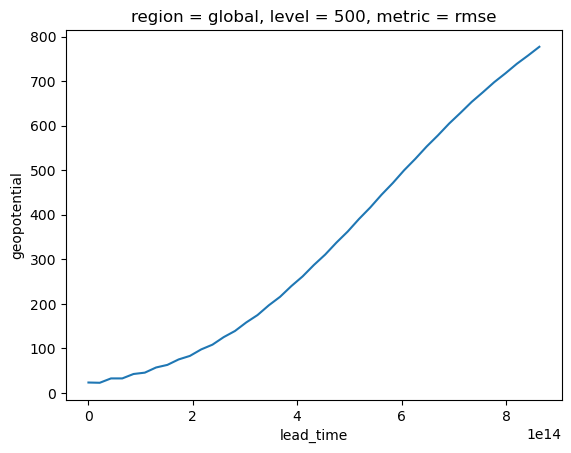

In [ ]:
results['geopotential'].sel(metric='rmse', level=500, region='global').plot();

### Next steps

This quickstart guide shows the basic functionality of the WeatherBench evaluation code but there is more to explore.

For running evaluation from the command line, see [this guide](https://weatherbench2.readthedocs.io/en/latest/command-line-scripts.html). For a complete overview of the entire evaluation workflow, check out the ["submission" guide](https://weatherbench2.readthedocs.io/en/latest/submit.html).